In [37]:
# loading the language label dictionary
itol_language = {0: 'surprise', 1: 'fear', 2: 'neutral', 3: 'sad', 4: 'happy', 5: 'anger', 6: 'disgust'}
# Loading the FER label dictionary
itol_FER = {0: 'anger', 1: 'sad', 2: 'surprise', 3: 'disgust', 4: 'happy', 5: 'neutral', 6: 'fear'}

There is label inconsistency, Thus one one label Dictionary will be choosen i.e. the FER label dictionary for the prediction.

In [2]:
import torch
device = "cpu" # if torch.cuda.is_available else "cpu"
device

'cpu'

# 1. Defining the language model and attributes

In [3]:
import torch
import torch.nn as nn
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_dim = 768
hidden_dim = 128
output_dim = 7
num_layers = 1

language_model = LSTMClassifier(input_dim, hidden_dim, output_dim, num_layers)
language_model.to(device)

LSTMClassifier(
  (lstm): LSTM(768, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=7, bias=True)
)

In [4]:
!git clone https://github.com/Bhattars1/MSc-Project-Expression-Recognition-

Cloning into 'MSc-Project-Expression-Recognition-'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 96 (delta 34), reused 34 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (96/96), 39.21 MiB | 8.78 MiB/s, done.
Resolving deltas: 100% (34/34), done.
Updating files: 100% (28/28), done.


In [5]:
language_model_state_dict = torch.load("MSc-Project-Expression-Recognition-/lstm_model.pth")
language_model.load_state_dict(language_model_state_dict)

<All keys matched successfully>

## 1.1. Preprocessing function

In [6]:
from transformers import BertTokenizer, BertModel

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [7]:
# Preprocessing function
def generate_bert_embeddings(sentence):
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True, max_length=512)
    # Generate embeddings
    with torch.no_grad():
        outputs = model(**inputs)
    # Extract embeddings of the [CLS] token (index 0) for the sentence
    cls_embedding = outputs.last_hidden_state[:, 0, :]
    return cls_embedding.float()

## 1.2. Prediction

In [8]:
# Prediction function
def predict_text_expression(text):
  with torch.inference_mode():
    embedded_text = generate_bert_embeddings(text).to(device)
    logits = language_model(embedded_text.unsqueeze(0))
    probs = torch.softmax(logits, dim=1).squeeze()
    label = probs.argmax(0)
    return itol_language[label.item()], label.item(), probs

## 1.3. Importing data and preprocessing

In [9]:
import random

# Define file paths
dialogues_text_path = 'MSc-Project-Expression-Recognition-/daily_dialouge/dialogues_text.txt'
dialogues_emotion_path = 'MSc-Project-Expression-Recognition-/daily_dialouge/dialogues_emotion.txt'

# Initialize lists to store sentences and their corresponding labels
sentences = []
labels = []

# Read dialogues from the text file
with open(dialogues_text_path, 'r') as text_file:
    raw_dialogues = text_file.readlines()

# Read labels from the emotion file
with open(dialogues_emotion_path, 'r') as label_file:
    raw_labels = label_file.readlines()

# Process each dialogue and corresponding label
for dialogue, label in zip(raw_dialogues, raw_labels):
    # Split the dialogue into individual sentences (utterances)
    utterances = dialogue.strip().split(" __eou__ ")

    # Split the label line into individual emotion labels
    label_list = list(map(int, label.strip().split()))

    # Append each cleaned sentence and its corresponding label to the lists
    for utterance, label in zip(utterances, label_list):
        cleaned_utterance = utterance.replace('__eou__', '').strip()  # Remove '__eou__' and trim spaces
        if cleaned_utterance:  # Only add if the utterance is not empty
            sentences.append(cleaned_utterance)
            labels.append(label)

print(len(sentences), len(labels))

102979 102979


In [10]:
# Create a dictionary to store sentences by category
category_sentences = {key: [] for key in range(7)}  # Adjust range according to your number of categories

# Populate the dictionary with sentences by category
for sentence, label in zip(sentences, labels):
    if label in category_sentences:
        category_sentences[label].append(sentence)

# Sample 174 items per category
sample_data = []
sample_labels = []

for category, cat_sentences in category_sentences.items():
    if len(cat_sentences) >= 19:
        sampled_sentences = random.sample(cat_sentences, 19)
        sample_data.extend(sampled_sentences)
        sample_labels.extend([category] * 19)
    else:
        print(f"Warning: Not enough samples for category {category}")

print(len(sample_data), len(sample_labels))

133 133


In [11]:
from collections import Counter
Counter(sample_labels)

Counter({0: 19, 1: 19, 2: 19, 3: 19, 4: 19, 5: 19, 6: 19})

In [12]:
# getting the text label dictionary from the dataset instruction
text_labels_dict = {
    0: "no emotion",
    1: "anger",
    2: "disgust",
    3: "fear",
    4: "happiness",
    5: "sadness",
    6: "surprise"
}

# 2. Defining the FER model and attributes

In [13]:
# Creating an instance of model
import torch
import torch.nn as nn
# Define the model
class TinyVGG(nn.Module):
    def __init__(self, conv1_channels=32, conv2_channels=64, fc1_units=128, dropout_rate=0.5, num_classes=7):
        super(TinyVGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, conv1_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(conv1_channels, conv2_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(conv2_channels * 16 * 16, fc1_units),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(fc1_units, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.reshape(x.size(0), -1)
        x = self.classifier(x)
        return x

# Create an instance of the model
TinyVGG_model = TinyVGG(conv1_channels=64, conv2_channels = 64, fc1_units=256, dropout_rate=0.5 ).to(device)
TinyVGG_model = TinyVGG_model.to(dtype=torch.float32)

In [14]:
TinyVGG_model_state_dict = torch.load("MSc-Project-Expression-Recognition-/TinyVGG.pth",map_location=torch.device(device))
TinyVGG_model.load_state_dict(TinyVGG_model_state_dict)

<All keys matched successfully>

In [15]:
TinyVGG_model

TinyVGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=16384, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=7, bias=True)
  )
)

## 2.1. Preprocessing function

In [16]:
# Cropping out the face using opencv model (Face detcetion)
import cv2
# Load the pre-trained Haar Cascade classifier
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
from google.colab.patches import cv2_imshow as image_show
import numpy as np

In [17]:
def image_crop(image):
    # Convert image to numpy array if it's not already
    image = np.array(image)

    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = gray_image.astype(np.uint8)

    # Perform face detection
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Check if at least one face is detected
    if len(faces) > 0:
        # Crop the face from the image (taking the first detected face)
        x, y, w, h = faces[0]
        cropped_face = image[y:y+h, x:x+w]
        return cropped_face

    # Return None if no face is detected
    return "No Face Detected!!!"

In [18]:
# Histogram Equalization using CLAHE and normalization
def clahe_func_normalization(image, clip_limit=2.0, grid_size=4):

    # Convert image to LAB color space
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

    # Split the LAB image into its channels
    l_channel, a_channel, b_channel = cv2.split(lab_image)

    # Apply CLAHE to the L channel
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(grid_size, grid_size))
    cl_l_channel = clahe.apply(l_channel)

    # Merge the CLAHE enhanced L channel back with A and B channels
    merged_lab_image = cv2.merge((cl_l_channel, a_channel, b_channel))

    # Convert the LAB image back to RGB color space
    clahe_image = cv2.cvtColor(merged_lab_image, cv2.COLOR_LAB2RGB)

    # Normalize the final image to the 0-1 range
    final_normalized_image = clahe_image / 255.0

    return final_normalized_image

In [19]:
# resizing the image and converting to the tensor
def resize_image(image, size=64):
    # Resize the image to the specified size
    resized_image = cv2.resize(image, (size, size))
    return resized_image
def to_tensor(image):
    tensor_image = torch.tensor(image).float()
    return tensor_image

In [20]:
# Preprocessing pipeline
def preprocessing_pipeline(image):
  image = image_crop(image)
  image = clahe_func_normalization(image)
  image = resize_image(image)
  image = to_tensor(image)
  return image

## 2.3. Prediction function

In [21]:
# Prediction fuction
def predict_FER(image):
  image = preprocessing_pipeline(image)
  with torch.inference_mode():
    pred_logits = TinyVGG_model(image.permute(2,0,1).unsqueeze(dim=0).to(torch.float32).to(device))

    # Get the prediction probabilities for our samples
    pred_probs = torch.softmax(pred_logits, dim=1)
    label = itol_FER[pred_probs.argmax(dim=1).item()]
  return label, pred_probs.argmax(dim=1).item(), pred_probs

## 2.4. Import data

In [22]:
# Mounting the drive to import dataset
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [23]:
# Importing necessary libraries to import the images
from tqdm.auto import tqdm
import os
from PIL import Image

# Set up the path to the new dataset
dataset_path = '/content/drive/MyDrive/gender/new test data/data'


# Initialize lists to store images and labels
images_list = []
labels_list = []

# Initialize dictionary to store label indices and labels
label_dict = {}

# Load images from each class folder
class_idx = 0

# Iterate over class folders
for class_name in tqdm(os.listdir(dataset_path)):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):

        # Assign label index
        label_dict[class_idx] = class_name

        # Iterate over image files in class folder
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            if os.path.isfile(img_path):

                # Load image and apply transformation
                image = Image.open(img_path)
                # Append image and label to respective lists
                images_list.append(image)
                labels_list.append(class_idx)
        class_idx += 1

# Display the number of images loaded for each class
print("Number of classes:", class_idx)
print("Total number of images:", len(images_list))

  0%|          | 0/8 [00:00<?, ?it/s]

Number of classes: 8
Total number of images: 152


## 2.5. Data filtering

In [24]:
# Removing the Contempt images


# Filter images and labels to remove those with the 'Contempt' label
filtered_images_list = []
filtered_labels_list = []

for img, lbl in zip(images_list, labels_list):
    if label_dict[lbl] != 'Contempt':
        filtered_images_list.append(img)
        filtered_labels_list.append(lbl)

# Adjust the label_dict to remove 'Contempt' and re-index starting from zero
filtered_label_dict = {}
label_mapping = {}
new_index = 0

for key, value in label_dict.items():
    if value != 'Contempt':
        label_mapping[key] = new_index
        filtered_label_dict[new_index] = value
        new_index += 1

# Map the filtered labels to the new label indices
filtered_labels_list = [label_mapping[label] for label in filtered_labels_list]

# Output the results
print("Filtered Images List Length:", len(filtered_images_list))
print("Filtered Labels List Length:", len(filtered_labels_list))
print("Filtered Label Dict:", filtered_label_dict)

Filtered Images List Length: 133
Filtered Labels List Length: 133
Filtered Label Dict: {0: 'happy', 1: 'disgust', 2: 'sad', 3: 'fear', 4: 'neutral', 5: 'surprised', 6: 'angry'}


In [25]:
Counter(filtered_labels_list)

Counter({0: 19, 1: 19, 2: 19, 3: 19, 4: 19, 5: 19, 6: 19})

# 3. Decision Fusion

There is a lot of label incosistency in the language model, FER, and the test datasets. Thus, for the data prepretation for decision fusion, test_image labels will be taken as base labels.

## 3.1. Data Prepraration

In [26]:
filtered_label_dict

{0: 'happy',
 1: 'disgust',
 2: 'sad',
 3: 'fear',
 4: 'neutral',
 5: 'surprised',
 6: 'angry'}

In [27]:
text_labels_dict

{0: 'no emotion',
 1: 'anger',
 2: 'disgust',
 3: 'fear',
 4: 'happiness',
 5: 'sadness',
 6: 'surprise'}

In [28]:
# the text labels will be changed to the base labels

# Creating the reverse mapping
reverse_mapping = {
    0: 4,  # 'no emotion' -> 'neutral'
    1: 6,  # 'anger' -> 'angry'
    2: 1,  # 'disgust' -> 'disgust'
    3: 3,  # 'fear' -> 'fear'
    4: 0,  # 'happiness' -> 'happy'
    5: 2,  # 'sadness' -> 'sad'
    6: 5   # 'surprise' -> 'surprised'
}
# Convert sample_labels using the reverse mapping
converted_labels = [reverse_mapping[label] for label in sample_labels]

In [29]:
Counter(converted_labels), Counter(filtered_labels_list)

(Counter({4: 19, 6: 19, 1: 19, 3: 19, 0: 19, 2: 19, 5: 19}),
 Counter({0: 19, 1: 19, 2: 19, 3: 19, 4: 19, 5: 19, 6: 19}))

In [30]:
# Making a tuple list of image and text to feed to decision fusion model

# Initialize lists to hold the result
tuples_list = []
labels_list = filtered_labels_list
# Create tuples (image, text) for each label
for img, txt in zip(filtered_images_list, sample_data):
    tuples_list.append((img, txt))

In [31]:
tuples_list[0]

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1448x3216>,
 "Oh ? I heard she dumped you . Anyway , she's right over there . Oh , Sheryl !")

In [32]:
len(labels_list), len(tuples_list)

(133, 133)

## 3.2. Data Visualization

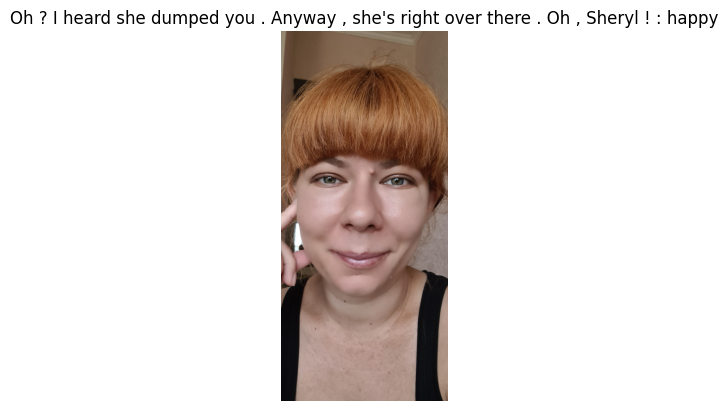

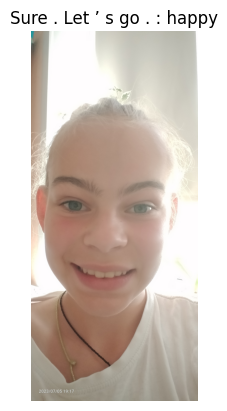

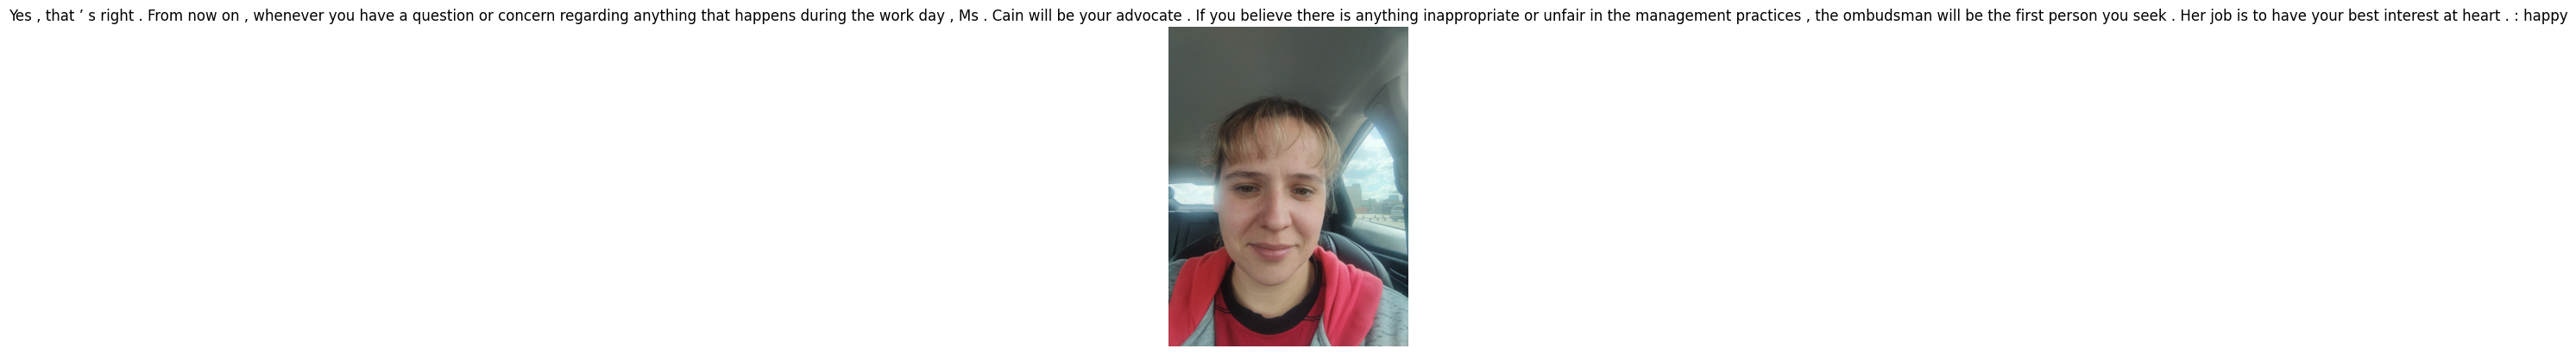

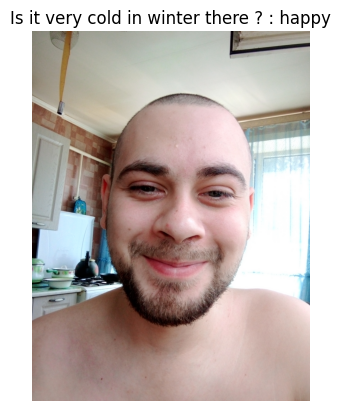

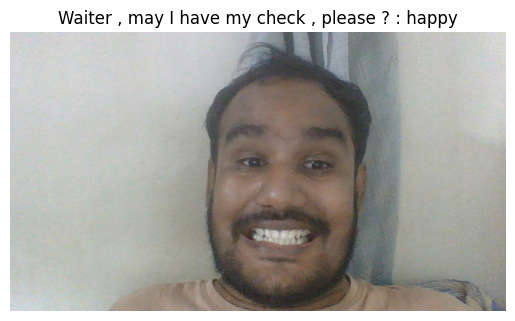

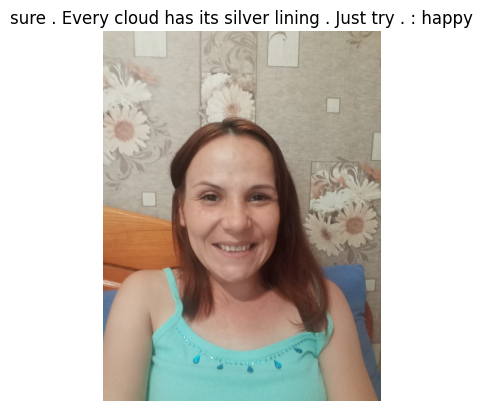

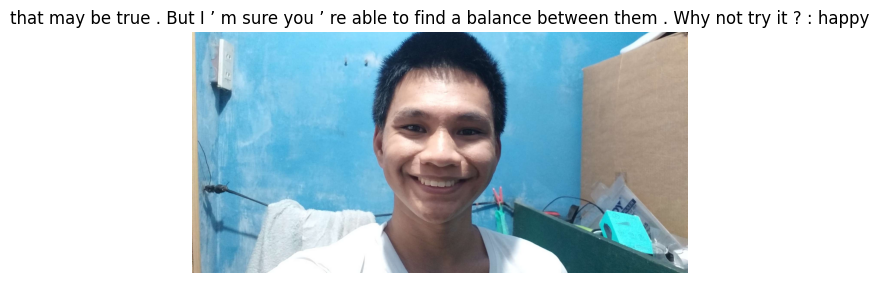

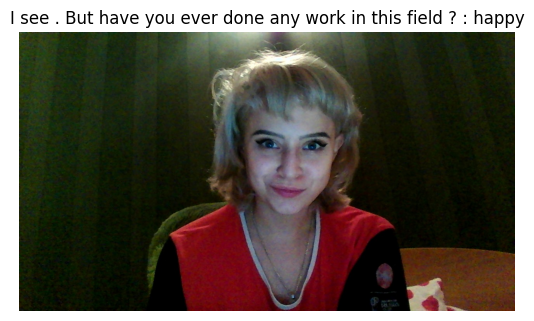

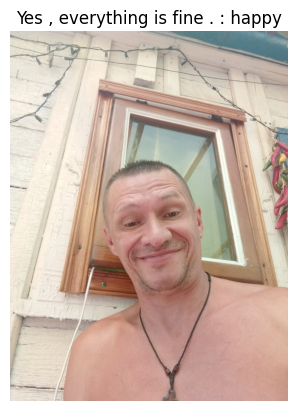

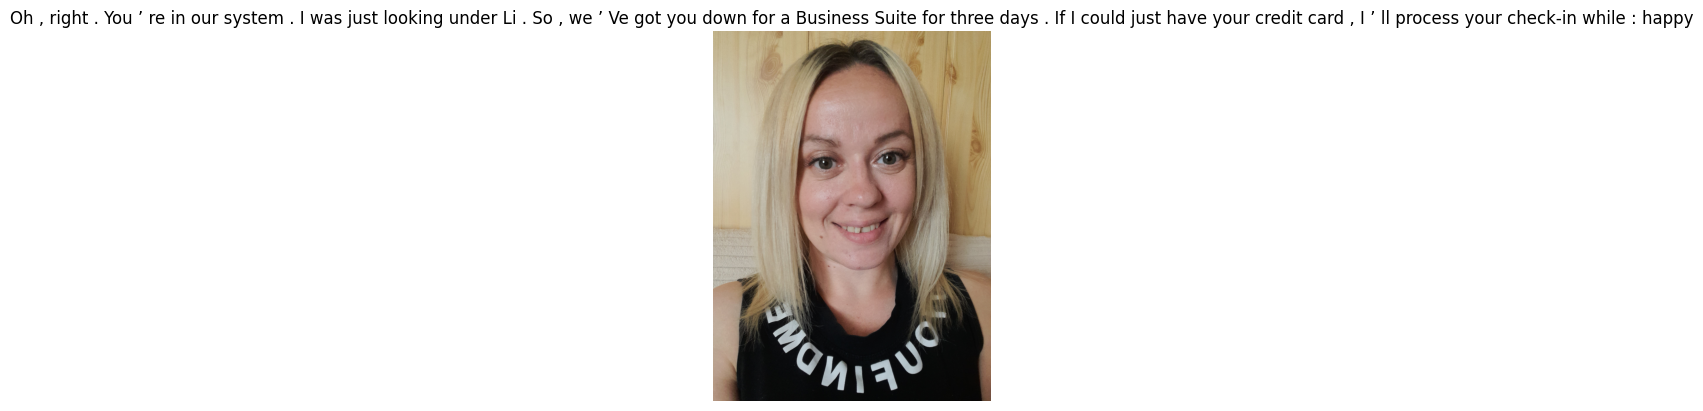

In [33]:
# Checking images and text
import matplotlib.pyplot as plt
for i, (image, text) in enumerate(tuples_list[:10]):
  plt.imshow(image)
  plt.title(f"{text} : {filtered_label_dict[labels_list[i]]}")
  plt.axis('off')
  plt.show();

## 3.3. Prediction, Testing and evaluation

In [39]:
# Defining Decision Fusion Function

import torch.nn.functional as F

def fusion_prediction(data, language_model=language_model, FER_model=TinyVGG_model, language_model_weight=1, FER_model_weight=1):
    with torch.inference_mode():
        image, text = data
        _, _, language_logits = predict_text_expression(text)
        _, _, FER_logits = predict_FER(image)
        language_probs = F.softmax(language_logits, dim=0)
        FER_probs = F.softmax(FER_logits, dim=1)
        fusion_probs = (language_probs * language_model_weight + FER_probs * FER_model_weight) / (language_model_weight + FER_model_weight)
        fusion_label = fusion_probs.argmax(dim=1).item()
        return filtered_label_dict[fusion_label], fusion_label, fusion_probs, language_probs, FER_probs

In [40]:
# Define the batch size
batch_size = 8
predicted_fusion_labels = []

for i in tqdm(range(0, len(tuples_list), batch_size)):
    batch = tuples_list[i:i + batch_size]
    for data in batch:
        _,pred_items,_,_,_ = fusion_prediction(data, language_model_weight=1, FER_model_weight=1)
        predicted_fusion_labels.append(pred_items)

  0%|          | 0/17 [00:00<?, ?it/s]

In [41]:
from sklearn.metrics import accuracy_score

# Calculate Accuracy
accuracy = accuracy_score(labels_list, predicted_fusion_labels)
print(f'Accuracy: {accuracy:.3f}')

Accuracy: 0.150


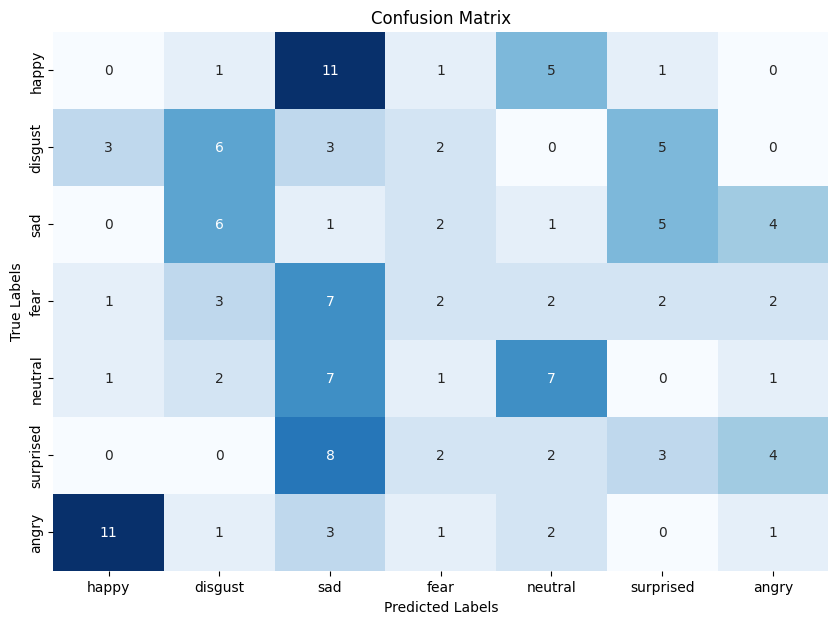

In [42]:
from sklearn.metrics import confusion_matrix

import seaborn as sns
import pandas as pd

# Dictionary for human-readable labels
label_dict = {0: 'happy', 1: 'disgust', 2: 'sad', 3: 'fear', 4: 'neutral', 5: 'surprised', 6: 'angry'}

# Generate Confusion Matrix
conf_matrix = confusion_matrix(labels_list, predicted_fusion_labels, labels=list(filtered_label_dict.keys()))
conf_matrix_df = pd.DataFrame(conf_matrix, index=[filtered_label_dict[i] for i in filtered_label_dict.keys()], columns=[filtered_label_dict[i] for i in filtered_label_dict.keys()])

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [43]:
from sklearn.metrics import classification_report

# Generate Classification Report
report = classification_report(labels_list, predicted_fusion_labels, target_names=[label_dict[i] for i in label_dict.keys()])
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

       happy       0.00      0.00      0.00        19
     disgust       0.32      0.32      0.32        19
         sad       0.03      0.05      0.03        19
        fear       0.18      0.11      0.13        19
     neutral       0.37      0.37      0.37        19
   surprised       0.19      0.16      0.17        19
       angry       0.08      0.05      0.06        19

    accuracy                           0.15       133
   macro avg       0.17      0.15      0.16       133
weighted avg       0.17      0.15      0.16       133

